In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import ogr
from scipy.spatial import Voronoi, voronoi_plot_2d

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph

# Necessary for the cooked test data
from unittest.mock import Mock
from unittest.mock import MagicMock
from autocnet.graph import edge
from autocnet.graph import node
from plio.io import io_gdal

from autocnet.transformation.transformations import Homography
from autocnet.utils.utils import array_to_poly

from IPython.display import display

%pylab inline
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def scale_poly(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [3]:
def compute_vor_weight(vor, voronoi_df, intersection_poly, verbose):
    i = 0
    poly_array = []
    vor_points = np.asarray(vor.points)
    for region in vor.regions:
        region_point = vor_points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = array_to_poly(polygon_points)
                intersection = polygon.Intersection(intersection_poly)
                poly_array = np.append(poly_array, intersection)  # To see unclipped, replace intersection with polygon
                polygon_area = intersection.GetArea()
                voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                               (voronoi_df["y"] == region_point[0][0][1]), 
                               'weights'] = polygon_area
        i+=1
    
    # Also for visualization of voronoi, adds the colored voronoi polygons to the image
    if (verbose):
        polygons = poly_array
        for i in polygons:
            geom = i.GetGeometryRef(0)
            if geom == None:
                continue
            else:
                points = geom.GetPoints()
                plt.fill(*zip(*points), alpha = .3)
    # End visualization section

In [4]:
def voronoi(edge, clean_keys=[], k = 30, verbose = False):
    source_corners = edge.source.geodata.xy_corners
    destination_corners = edge.destination.geodata.xy_corners
    
    matches, _ = edge.clean(clean_keys=clean_keys)
    
    source_keypoints_pd = edge.source.get_keypoint_coordinates(index=matches['source_idx'], homogeneous=True)
    destination_keypoints_pd = edge.destination.get_keypoint_coordinates(index=matches['destination_idx'], homogeneous=True)
    
    if edge.source.geodata.coordinate_transformation.this != None:
        source_footprint_poly = edge.source.geodata.footprint
        destination_footprint_poly = edge.destination.geodata.footprint

        intersection_poly = destination_footprint_poly.Intersection(source_footprint_poly)
        intersection_geom = intersection_poly.GetGeometryRef(0)
        intersect_points = intersection_geom.GetPoints()
        
        data = source_keypoints_pd
        intersection_points = [edge.source.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]
            
    else:
        H, mask = cv2.findHomography(destination_keypoints_pd.values,
                                     source_keypoints_pd.values,
                                     cv2.RANSAC,
                                     2.0)
        
        proj_corners = []
        for c in destination_corners:
            x, y, h = reproj_point(H, c)
            x /= h
            y /= h
            h /= h
            proj_corners.append((x, y))
            
        orig_poly = array_to_poly(source_corners)
        proj_poly = array_to_poly(proj_corners)

        intersection_poly = orig_poly.Intersection(proj_poly)
        intersection_geom = intersection_poly.GetGeometryRef(0)
        intersection_points = intersection_geom.GetPoints()
        
    centroid = intersection_poly.Centroid().GetPoint()

    # Method for displaying the images transformed using the homography, should be used in the visualiation
    if verbose & (edge.source.geodata.coordinate_transformation.this == None):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.add_patch(Polygon(source_corners, facecolor='blue',alpha=0.25, edgecolor='k'))
        ax1.add_patch(Polygon(proj_corners, facecolor='red', alpha=0.25, edgecolor='k'))
    else:
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111, aspect='equal')
        ax1.add_patch(Polygon(source_corners, facecolor='blue',alpha=0.25, edgecolor='k'))
        ax1.add_patch(Polygon(destination_corners, facecolor='red', alpha=0.25, edgecolor='k'))
    # End visualization section
    
    voronoi_df = pd.DataFrame(data=source_keypoints_pd, columns=["x", "y", "weights"])

    voronoi_df["x"] = source_keypoints_pd['x']
    voronoi_df["y"] = source_keypoints_pd['y']
    keypoints = np.asarray(source_keypoints_pd)
    
    inters = np.empty((len(intersection_points),2))
    
    for g, (i, j) in enumerate(intersection_points):
        scaledx, scaledy = scale_poly((i, j), centroid, k)
        point = np.array([scaledx, scaledy])
        inters[g] = point

    keypoints = np.vstack((keypoints[:,:2], inters))
    vor = Voronoi(keypoints)
    i = 0
    poly_array = []
    vor_points = np.asarray(vor.points)
    for region in vor.regions:
        region_point = vor_points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = array_to_poly(polygon_points)
                intersection = polygon.Intersection(intersection_poly)
                poly_array = np.append(poly_array, intersection)  # To see unclipped, replace intersection with polygon
                polygon_area = intersection.GetArea()
                voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                               (voronoi_df["y"] == region_point[0][0][1]), 
                               'weights'] = polygon_area
        i+=1
    
    # Also for visualization of voronoi, adds the colored voronoi polygons to the image
    if (verbose):
        polygons = poly_array
        for i in polygons:
            geom = i.GetGeometryRef(0)
            if geom == None:
                continue
            else:
                points = geom.GetPoints()
                plt.fill(*zip(*points), alpha = .3)
    # End visualization section

    return vor, voronoi_df

In [5]:
def reproj_point(H, point):
    """
    Reproject a pixel in one image into another image
    
    Parameters
    ----------
    H : object
        (3,3) ndarray or Homography object
        
    corner : iterable
             A 2 element iterable in the form x, y
    """
    if len(point) == 2:
        coords = np.array([point[0],point[1],1])
    elif len(point) == 3:
        coords = np.asarray(point)
        coords *= coords[-1]  # Homogenize
    
    return H.dot(coords)

Getting CT
CT <osgeo.osr.CoordinateTransformation; proxy of None >


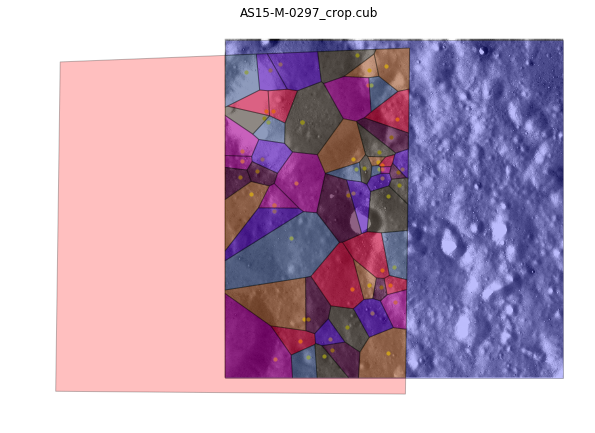

In [6]:
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':1000})

#Match
cg.match_features()

#Apply outlier detection
cg.symmetry_checks()
cg.ratio_checks()

#Compute a homography and apply RANSAC
cg.compute_fundamental_matrices(clean_keys=['ratio', 'symmetry'])

cg.compute_homographies(clean_keys = ['fundamental'], reproj_threshold = .5)

edge = cg.edge[1][2]

# Destination is working
vor = voronoi(edge, clean_keys = ['fundamental'], k = 50, verbose = True)
matches, mask = edge.clean(clean_keys = ['fundamental'])
edge.source.plot(index_mask = matches['source_idx'], color = 'yellow', s = 40)
edge.compute_weights(clean_keys = ['fundamental'])
show()

In [7]:
adjacency = get_path('two_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
keypoint_df = pd.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (5, 10, 15, 15, 10)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pd.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge

e.clean = MagicMock(return_value=(matches_df, None))

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(10, 5),
                       (30, 5),
                       (30, 25),
                       (10, 25)]

source_xy_extent = [(0, 20), (0, 20)]

destination_xy_extent = [(10, 30), (5, 25)]

source_poly = array_to_poly(source_corners)
destination_poly = array_to_poly(destination_corners)

vals = {(10, 5):(10, 5), (20, 5):(20, 5), (20, 20):(20, 20), (10, 20):(10, 20)}

def latlon_to_pixel(i, j):
    return vals[(i, j)]

e.source.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)
e.destination.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)

e.source.geodata.footprint = source_poly
e.source.geodata.xy_corners = source_corners
e.source.geodata.xy_extent = source_xy_extent
e.destination.geodata.footprint = destination_poly
e.destination.geodata.xy_corners = destination_corners
e.destination.geodata.xy_extent = destination_xy_extent

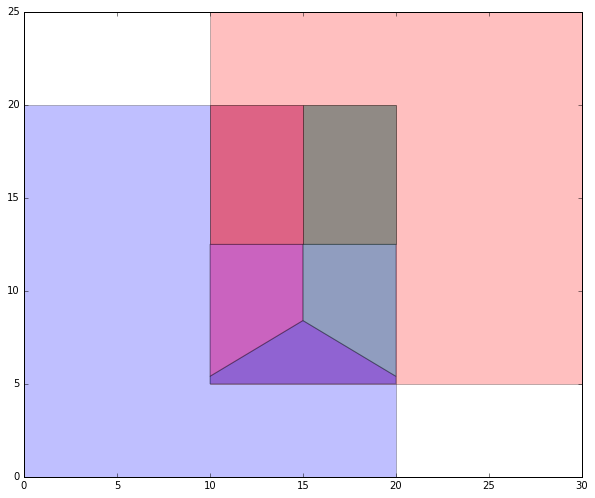

In [8]:
vor = voronoi(e, clean_keys=[], verbose = True, k = 30)

In [9]:
# adjacency = get_path('two_image_adjacency.json')
# basepath = get_path('Apollo15')
# cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
source_keypoint_df = pd.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (5, 10, 15, 15, 10)})
destination_keypoint_df = pd.DataFrame({'x': (5, 8, 8, 2, 2), 'y': (0, 5, 10, 10, 5)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pd.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge

e.clean = MagicMock(return_value=(matches_df, None))

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=source_keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=destination_keypoint_df)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(0, 0),
                       (20, 0),
                       (20, 20),
                       (0, 20)]

e.source.geodata.coordinate_transformation.this = None
e.destination.geodata.coordinate_transformation.this = None

e.source.geodata.xy_corners = source_corners
e.destination.geodata.xy_corners = destination_corners

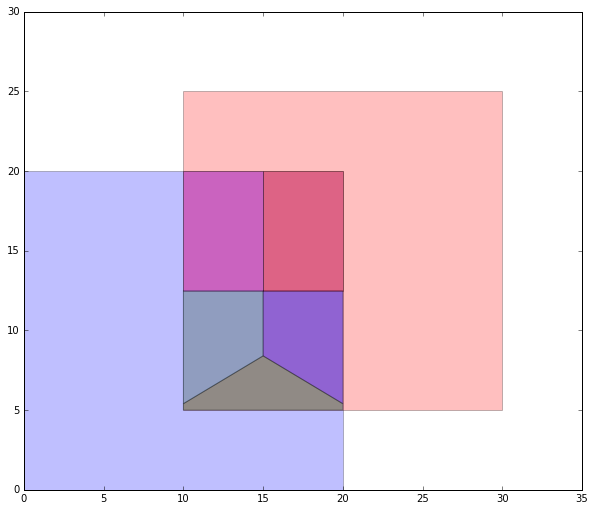

In [10]:
vor = voronoi(e, clean_keys = [], verbose = True)